In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Load the dataset
shayari = pd.read_csv("dataset.csv", encoding='utf-16', header=None, sep='\t', names=['text','labels'])

In [4]:
# Tokenize the text
tokenized_text = [word_tokenize(sentence) for sentence in shayari['text']]

In [5]:
# Encode the poet labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(shayari['labels'])

In [6]:
# Initialize the tokenizer
tokenizer = Tokenizer()

In [7]:
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(shayari['text'])

In [8]:
# Convert text to sequences of integer indices
encoded_sequences = tokenizer.texts_to_sequences(shayari['text'])

In [9]:
# Padding sequences to a fixed length
max_length = 128  # Adjust as needed based on your dataset
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_length, padding='post', truncating='post')

In [10]:
# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [11]:
# Print the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (14087, 128) (14087,)
Validation set shape: (1761, 128) (1761,)
Test set shape: (1761, 128) (1761,)


In [12]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForMaskedLM

In [13]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [14]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertForMaskedLM.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [15]:
# Compile the model with mixed precision
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [16]:
# Compile the model with mixed precision
optimizer = tf.optimizers.Adam()  # Use TensorFlow's Adam optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [17]:
# Train the model with GPU acceleration
history = model.fit(padded_sequences, padded_sequences, epochs=2, validation_split=0.2, batch_size=32, verbose=1)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
441/441 [==============================] - 983s 2s/step - loss: 1.8430 - accuracy: 0.7339 - val_loss: 1.3011 - val_accuracy: 0.8380
Epoch 2/2
441/441 [==============================] - 888s 2s/step - loss: 1.3106 - accuracy: 0.8487 - val_loss: 1.3020 - val_accuracy: 0.8548


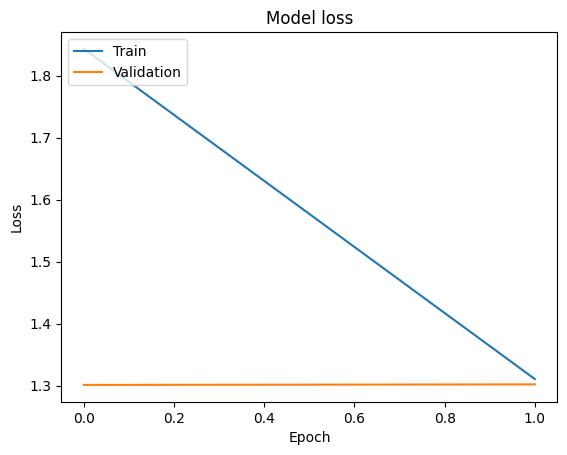

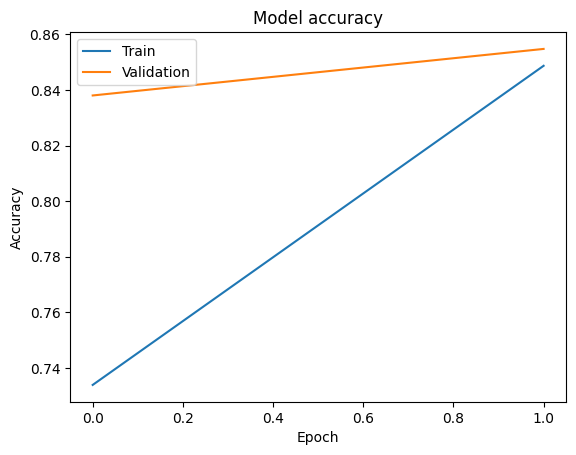

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
print("Training History:")
print(history.history)

Training History:
{'loss': [1.8430372476577759, 1.310577392578125], 'accuracy': [0.7338677048683167, 0.848700225353241], 'val_loss': [1.3011376857757568, 1.3020048141479492], 'val_accuracy': [0.8380206227302551, 0.8547691702842712]}


In [23]:
from transformers import BertTokenizer, TFBertLMHeadModel

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertLMHeadModel.from_pretrained("bert-base-multilingual-cased")

# Choose a seed text
seed_text = "سنا ہے "

# Tokenize the seed text
tokenized_seed = tokenizer.encode(seed_text, add_special_tokens=True, return_tensors="tf")

# Generate poetry using the trained model
max_length = 100  # Adjust as needed
generated_tokens = model.generate(input_ids=tokenized_seed, max_length=max_length, num_return_sequences=1, temperature=0.7)

# Decode generated tokens into text
generated_poetry = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

# Print the generated poetry
print("Generated Poetry:")
print(generated_poetry)


If you want to use `TFBertLMHeadModel` as a standalone, add `is_decoder=True.`
All PyTorch model weights were used when initializing TFBertLMHeadModel.

All the weights of TFBertLMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertLMHeadModel for predictions without further training.


Generated Poetry:
سنا ہے کہ دل کی باتوں میں خواب ہوتا ہے دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل دل


In [25]:
# Choose a seed text
seed_text = "محبت"

# Tokenize the seed text
tokenized_seed = tokenizer.encode(seed_text, add_special_tokens=True, return_tensors="tf")

# Generate poetry using the trained model
max_length = 100  # Adjust as needed
generated_tokens = model.generate(input_ids=tokenized_seed, max_length=max_length, num_return_sequences=1, temperature=0.7)

# Decode generated tokens into text
generated_poetry = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

# Print the generated poetry
print("Generated Poetry:")
print(generated_poetry)


Generated Poetry:
محبت کی راہوں میں کھویا بیٹھا ہے کوئی, راستوں کی تھل گرم مکھن میں چھپا ہے کوئی ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ،


In [ ]:
# Print the generated tokens
print("Generated Tokens:")
print(generated_tokens)


Generated Tokens:
tf.Tensor(
[[  101   788 84162 10691 32914 23856   775 67499 79130   102   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118   118   118   118   118   118   118   118   118
    118   118   118   118]], shape=(1, 100), dtype=int32)


In [ ]:
# Choose a descriptive seed text
seed_text = "سنا ہے لوگ اسے آنکھ بھر کے دیکھتے ہیں۔"

# Tokenize the seed text
tokenized_seed = tokenizer.encode(seed_text, add_special_tokens=True, return_tensors="tf")

# Generate poetry using the trained model
max_length = 100  # Adjust as needed
generated_tokens = model.generate(input_ids=tokenized_seed, max_length=max_length, num_return_sequences=1, temperature=0.9)

# Decode generated tokens into text
generated_poetry = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

# Print the generated poetry
print("Generated Poetry:")
print(generated_poetry)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Poetry:
سنا ہے لوگ اسے آنکھ بھر کے دیکھتے ہیں ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
